<center><h1>US Presidents Inaugural Speech Analysis</h1></center>
<center><img src="hqdefault.jpg"></center>

## Introduction

The data set is made up of 58 files each containing the speech of inaugural speech of all American presidents.




In [188]:
# !pip install -r requirement.txt

## Imports and function definitions


In [189]:
import glob
import string
import re
import random
import pandas as pd
from collections import defaultdict
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

import pyLDAvis.gensim as gensimvis
import pyLDAvis

from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram

stop_words = list(set(stopwords.words('english') + list(ENGLISH_STOP_WORDS)))
lemmatizer = WordNetLemmatizer()

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


def get_info():
    global index, values, label, val
    for index in range(fit.n_clusters):
        values = indices[int(index)]
        label = [labels[val] for val in values]
        print(50 * "-")
        print("Cluster %s Information" % index)
        for val in set(label):
            print("Value:", str(val), "Count:", str(label.count(val)))

def get_data_df(file_path):
    df = pd.DataFrame(columns=['year', 'prez_name', 'speech'])
    for file in glob.glob("speeches/*.txt"):
        prez_name = file.split('\\')[1].split('-')[1].split('.')[0]
        year = file.split('\\')[1].split('-')[0]
        with open(file, 'r') as f:
            df.loc[len(df)] = [year, prez_name, f.read()]
    return df

def count_vec2df(wm, feat_names):
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names, columns=feat_names)
    return (df)

def preprocess_text(text):
    text = text.lower()  # lower case
    text = re.sub(r'[' + string.punctuation + ']+', ' ', text)  # strip punctuation
    text = re.sub(r'\s+', ' ', text)  #remove double spacing
    text = re.sub(r'([0-9]+)', '', text)  # remove numbers
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')
                     if word not in stop_words and len(word) > 2])
    return text

def tokenize(text):
    return [token for token in simple_preprocess(text)]

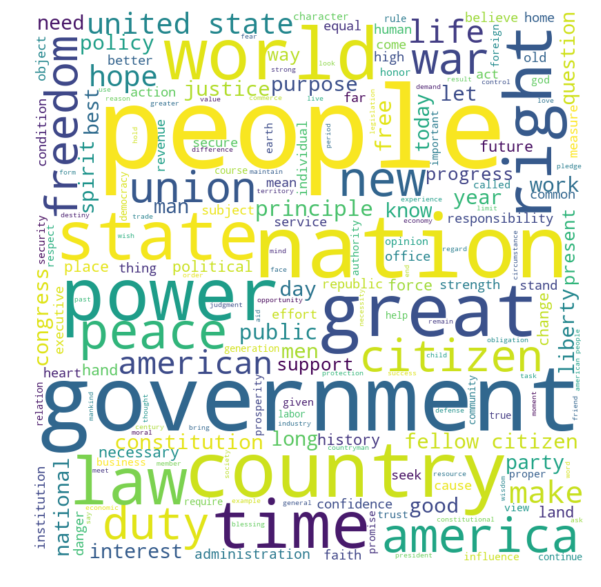

In [190]:
speeches_df = get_data_df("speeches/*.txt")
speeches_df['processed_speech'] = speeches_df.speech.map(preprocess_text) 

all_text = " ".join(speeches_df.processed_speech.tolist())
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(all_text)

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

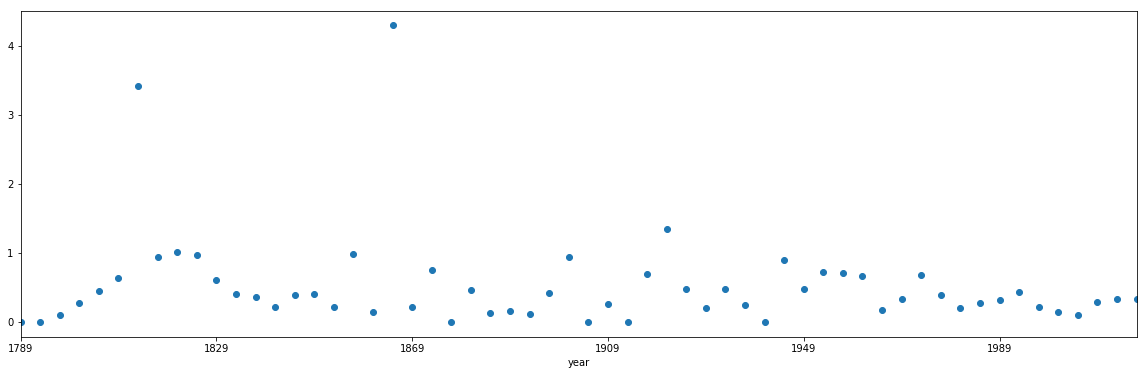

In [240]:
theme_words = 'military,war'
words = theme_words.split(',')
speeches_df['theme_words_percent_usage']=speeches_df.processed_speech.map(lambda x: sum([x.count(" "+preprocess_text(word.lower())) for word in words])/len(x.split())*100)
speeches_df.plot(kind = 'line', x='year', y='theme_words_percent_usage', legend=False, figsize =(20, 6), linestyle="None", marker="o", )
plt.show()

In [192]:
doc_term_vect = CountVectorizer(ngram_range=(1, 2),
                       min_df=2, # only keep terms that appear in at least 2 documents
                       max_df=0.5, # ignore terms that appear in more than 50% of the documents
                       token_pattern=r'\w{2,}' #vectorize 2-character words or more
                       )
bag_of_words = doc_term_vect.fit_transform(speeches_df.processed_speech.tolist())
doc_term_mtx_df = count_vec2df(bag_of_words, doc_term_vect.get_feature_names())
doc_term_mtx_df.to_csv("project4_dtm.csv")

# tf_id_vect = TfidfVectorizer(ngram_range=(1, 2),
#                              token_pattern=r'\w{2,}'
#                             )
# tf_id_mtx = tf_id_vect.fit_transform(speeches_df.processed_speech.tolist())
# tf_id_mtx_df = count_vec2df(tf_id_mtx, tf_id_vect.get_feature_names())
# tf_id_mtx_df.to_csv("project4_tf_id_mtx.csv")

get the number of k...


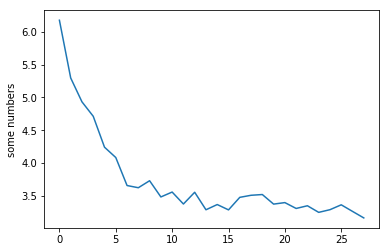

In [193]:
scores = []
sum_of_squared_distances = []
print("get the number of k...")
for k in range(2, 30):
    km = KMeans(n_clusters=k).fit(bag_of_words)
    sc = metrics.calinski_harabaz_score(bag_of_words.toarray(), km.labels_)
    scores.append(sc)
    sum_of_squared_distances.append(km.inertia_)
    
plt.plot(scores)
plt.ylabel('some numbers')
plt.show()

In [250]:
feature_vector = bag_of_words
feature_vector = tf_id_mtx
k=15

fit = KMeans(n_clusters=k).fit(feature_vector)
speeches_df['km_classes']  = fit.labels_
# labels = fit.labels_
# indices = {i: np.where(fit.labels_ == i)[0] for i in range(fit.n_clusters)}
# get_info()

# hac = AgglomerativeClustering(n_clusters=k)
# fit_hac = hac.fit(feature_vector.toarray())
# speeches_df['hac_classes'] = fit_hac.labels_
# labels = fit.labels_
# # indices = {i: np.where(fit.labels_ == i)[0] for i in range(fit_hac.n_clusters)}
# # get_info()

# plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
# plot_dendrogram(fit_hac)
# plt.show()

speeches_df.head()

,year,prez_name,speech,processed_speech,theme_words,km_classes,hac_classes,theme_words_percent_usage
0,1789,Washington,Fellow-Citizens of the Senate and of the House...,fellow citizen senate house representative vic...,0.000000,4,2,0.000000
1,1793,Washington,"Fellow citizens, I am again called upon by the...",fellow citizen called voice country execute fu...,0.000000,8,7,0.000000
2,1797,Adams,"When it was first perceived, in early times, t...",perceived early time middle course america rem...,0.103199,3,4,0.103199
3,1801,Jefferson,Friends and Fellow Citizens:\n\nCalled upon to...,friend fellow citizen called undertake duty ex...,0.277008,3,5,0.277008
4,1805,Jefferson,"Proceeding, fellow citizens, to that qualifica...",proceeding fellow citizen qualification consti...,0.448430,4,5,0.448430


In [254]:
documents = speeches_df.processed_speech.tolist()
texts = [tokenize(document) for document in documents]
all_text = " ".join(speeches_df.processed_speech.tolist())
frequency = Counter(all_text.split())
texts = [[token for token in text if frequency[token] > 10] for text in texts]
 
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# fit LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                           id2word=dictionary,
                           num_topics=NUM_TOPICS,
                           passes=20)

for topic in ldamodel.print_topics(num_words=20):
    print(topic)

# vis_data = gensimvis.prepare(ldamodel, corpus, dictionary)
# pyLDAvis.display(vis_data)

(0, '0.024*"nation" + 0.021*"people" + 0.021*"world" + 0.015*"peace" + 0.011*"freedom" + 0.011*"free" + 0.010*"country" + 0.009*"life" + 0.008*"united" + 0.008*"new" + 0.008*"men" + 0.008*"security" + 0.008*"democracy" + 0.008*"effort" + 0.007*"believe" + 0.007*"right" + 0.007*"program" + 0.007*"justice" + 0.006*"state" + 0.006*"shall"')
(1, '0.020*"government" + 0.019*"state" + 0.015*"people" + 0.013*"power" + 0.011*"country" + 0.010*"constitution" + 0.010*"citizen" + 0.010*"shall" + 0.009*"great" + 0.009*"public" + 0.009*"union" + 0.009*"nation" + 0.008*"right" + 0.008*"duty" + 0.007*"united" + 0.006*"law" + 0.006*"principle" + 0.006*"war" + 0.005*"time" + 0.005*"fellow"')
(2, '0.001*"nation" + 0.001*"people" + 0.001*"world" + 0.001*"government" + 0.001*"shall" + 0.001*"time" + 0.001*"power" + 0.001*"state" + 0.001*"american" + 0.001*"new" + 0.001*"let" + 0.001*"country" + 0.001*"war" + 0.001*"life" + 0.001*"spirit" + 0.001*"great" + 0.001*"right" + 0.001*"citizen" + 0.001*"free" + 0

In [259]:
# corpus

In [197]:
# doc_term_vect.vocabulary_['immigration']
# # speeches_df
# tf_id_vect.idf_
# print(list(zip(tf_id_vect.get_feature_names(), tf_id_vect.idf_)))
# all_text1= " ".join(speeches_df.processed_speech.tolist())
all_text = " ".join(speeches_df.speech.tolist())
# speeches_topics.
# all_text